## Setup

You will need to make a copy of this notebook in your Google Drive before you can edit the homework files. You can do so with **File &rarr; Save a copy in Drive**.

In [2]:
#@title mount your Google Drive
#@markdown Your work will be stored in a folder called `cs285_f2023` by default to prevent Colab instance timeouts from deleting your edits.

import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
#@title set up mount symlink

DRIVE_PATH = '/content/gdrive/My\ Drive/cs285_f2023'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/cs285_f2023'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

In [4]:
#@title apt install requirements

#@markdown Run each section with Shift+Enter

#@markdown Double-click on section headers to show code.

!apt update
!apt install -y --no-install-recommends \
        build-essential \
        curl \
        git \
        gnupg2 \
        make \
        cmake \
        ffmpeg \
        swig \
        libz-dev \
        unzip \
        zlib1g-dev \
        libglfw3 \
        libglfw3-dev \
        libxrandr2 \
        libxinerama-dev \
        libxi6 \
        libxcursor-dev \
        libgl1-mesa-dev \
        libgl1-mesa-glx \
        libglew-dev \
        libosmesa6-dev \
        lsb-release \
        ack-grep \
        patchelf \
        wget \
        xpra \
        xserver-xorg-dev \
        ffmpeg
!apt-get install python-opengl -y
!apt install xvfb -y

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [965 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,233 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,064 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,254 kB]
Hit:13 https://ppa.launchpa

In [5]:

#@title clone homework repo

%cd $SYM_PATH
!git clone https://github.com/berkeleydeeprlcourse/homework_fall2023.git
%cd homework_fall2023
%cd hw1
%pip install -r requirements_colab.txt
%pip install -e .

/content/gdrive/My Drive/cs285_f2023
fatal: destination path 'homework_fall2023' already exists and is not an empty directory.
/content/gdrive/My Drive/cs285_f2023/homework_fall2023
/content/gdrive/My Drive/cs285_f2023/homework_fall2023/hw1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.5/374.5 kB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.2/208.2 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.8 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.8-cp310-cp310-linux_x86_64.whl size=2349117 sha256=75bb291ccc8d98a10b944f27dcb21c7e105ae6899755c95ac193aae

Obtaining file:///content/gdrive/My%20Drive/cs285_f2023/homework_fall2023/hw1
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cs285


In [6]:
#@title set up virtual display

from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()

In [7]:
#@title test virtual display

#@markdown If you see a video of a four-legged ant fumbling about, setup is complete!

import gym
from cs285.infrastructure.colab_utils import (
    wrap_env,
    show_video
)

env = wrap_env(gym.make("Ant-v4", render_mode='rgb_array'))

observation = env.reset()
for i in range(100):
    env.render()
    obs, rew, term, _ = env.step(env.action_space.sample() )
    if term:
      break;

env.close()
print('Loading video...')
show_video()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Loading video...


## Editing Code

To edit code, click the folder icon on the left menu. Navigate to the corresponding file (`cs285_f2020/...`). Double click a file to open an editor. You will need to edit code in the following files:
```markdown
* cs285/policies/MLP_policy.py
* cs285/infrastructure/utils.py
* cs285/scripts/run_hw1.py
```

## Run Behavior Cloning (Problem 1)

Note that there is a timeout of about ~12 hours with Colab while it is active (and less if you close your browser window). We sync your edits to Google Drive so that you won't lose your work in the event of an instance timeout, but you will need to re-mount your Google Drive and re-install packages with every new instance.

In [8]:
#@title imports

import time

from cs285.scripts.run_hw1 import run_training_loop

%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred

In [9]:
#@title runtime arguments

class Args:

  def __getitem__(self, key):
    return getattr(self, key)

  def __setitem__(self, key, val):
    setattr(self, key, val)

  #@markdown expert data
  expert_policy_file = 'cs285/policies/experts/Ant.pkl' #@param
  expert_data = 'cs285/expert_data/expert_data_Ant-v4.pkl' #@param
  env_name = 'Ant-v4' #@param ['Ant-v4', 'Walker2d-v4', 'HalfCheetah-v4', 'Hopper-v4']
  exp_name = 'bc_ant' #@param
  do_dagger = True #@param {type: "boolean"}
  ep_len = 1000 #@param {type: "integer"}
  save_params = False #@param {type: "boolean"}

  num_agent_train_steps_per_iter = 1000 #@param {type: "integer"})
  n_iter = 5 #@param {type: "integer"})

  #@markdown batches & buffers
  batch_size_initial = 2000 #@param {type: "integer"})
  batch_size = 1000 #@param {type: "integer"})
  eval_batch_size = 1000 #@param {type: "integer"}
  train_batch_size = 100 #@param {type: "integer"}
  max_replay_buffer_size = 1000000 #@param {type: "integer"}

  #@markdown network
  n_layers = 2 #@param {type: "integer"}
  size = 64 #@param {type: "integer"}
  learning_rate = 5e-3 #@param {type: "number"}

  #@markdown logging
  video_log_freq = 5 #@param {type: "integer"}
  scalar_log_freq = 1 #@param {type: "integer"}

  #@markdown gpu & run-time settings
  no_gpu = False #@param {type: "boolean"}
  which_gpu = 0 #@param {type: "integer"}
  seed = 1 #@param {type: "integer"}

args = Args()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
#@title runtime arguments

class ArgsBCAnt:

  def __getitem__(self, key):
    return getattr(self, key)

  def __setitem__(self, key, val):
    setattr(self, key, val)

  #@markdown expert data
  expert_policy_file = 'cs285/policies/experts/Ant.pkl' #@param
  expert_data = 'cs285/expert_data/expert_data_Ant-v4.pkl' #@param
  env_name = 'Ant-v4' #@param ['Ant-v4', 'Walker2d-v4', 'HalfCheetah-v4', 'Hopper-v4']
  exp_name = 'bc_ant' #@param
  do_dagger = False #@param {type: "boolean"}
  ep_len = 1000 #@param {type: "integer"}
  save_params = False #@param {type: "boolean"}

  num_agent_train_steps_per_iter = 1000 #@param {type: "integer"})
  n_iter = 1 #@param {type: "integer"})

  #@markdown batches & buffers
  batch_size_initial = 2000 #@param {type: "integer"})
  batch_size = 1000 #@param {type: "integer"})
  eval_batch_size = 5000 #@param {type: "integer"}
  train_batch_size = 100 #@param {type: "integer"}
  max_replay_buffer_size = 1000000 #@param {type: "integer"}

  #@markdown network
  n_layers = 2 #@param {type: "integer"}
  size = 64 #@param {type: "integer"}
  learning_rate = 5e-3 #@param {type: "number"}

  #@markdown logging
  video_log_freq = -1 #@param {type: "integer"}
  scalar_log_freq = 1 #@param {type: "integer"}

  #@markdown gpu & run-time settings
  no_gpu = False #@param {type: "boolean"}
  which_gpu = 0 #@param {type: "integer"}
  seed = 1 #@param {type: "integer"}


class ArgsBCHopper:

  def __getitem__(self, key):
    return getattr(self, key)

  def __setitem__(self, key, val):
    setattr(self, key, val)

  #@markdown expert data
  expert_policy_file = 'cs285/policies/experts/Hopper.pkl' #@param
  expert_data = 'cs285/expert_data/expert_data_Hopper-v4.pkl' #@param
  env_name = 'Hopper-v4' #@param ['Ant-v4', 'Walker2d-v4', 'HalfCheetah-v4', 'Hopper-v4']
  exp_name = 'bc_hopper' #@param
  do_dagger = False #@param {type: "boolean"}
  ep_len = 1000 #@param {type: "integer"}
  save_params = False #@param {type: "boolean"}

  num_agent_train_steps_per_iter = 1000 #@param {type: "integer"})
  n_iter = 1 #@param {type: "integer"})

  #@markdown batches & buffers
  batch_size_initial = 2000 #@param {type: "integer"})
  batch_size = 1000 #@param {type: "integer"})
  eval_batch_size = 5000 #@param {type: "integer"}
  train_batch_size = 100 #@param {type: "integer"}
  max_replay_buffer_size = 1000000 #@param {type: "integer"}

  #@markdown network
  n_layers = 2 #@param {type: "integer"}
  size = 64 #@param {type: "integer"}
  learning_rate = 5e-3 #@param {type: "number"}

  #@markdown logging
  video_log_freq = -1 #@param {type: "integer"}
  scalar_log_freq = 1 #@param {type: "integer"}

  #@markdown gpu & run-time settings
  no_gpu = False #@param {type: "boolean"}
  which_gpu = 0 #@param {type: "integer"}
  seed = 1 #@param {type: "integer"}



class ArgsDAggerAnt:

  def __getitem__(self, key):
    return getattr(self, key)

  def __setitem__(self, key, val):
    setattr(self, key, val)

  #@markdown expert data
  expert_policy_file = 'cs285/policies/experts/Ant.pkl' #@param
  expert_data = 'cs285/expert_data/expert_data_Ant-v4.pkl' #@param
  env_name = 'Ant-v4' #@param ['Ant-v4', 'Walker2d-v4', 'HalfCheetah-v4', 'Hopper-v4']
  exp_name = 'bc_ant' #@param
  do_dagger = True #@param {type: "boolean"}
  ep_len = 1000 #@param {type: "integer"}
  save_params = False #@param {type: "boolean"}

  num_agent_train_steps_per_iter = 1000 #@param {type: "integer"})
  n_iter = 10 #@param {type: "integer"})

  #@markdown batches & buffers
  batch_size_initial = 2000 #@param {type: "integer"})
  batch_size = 1000 #@param {type: "integer"})
  eval_batch_size = 5000 #@param {type: "integer"}
  train_batch_size = 100 #@param {type: "integer"}
  max_replay_buffer_size = 1000000 #@param {type: "integer"}

  #@markdown network
  n_layers = 2 #@param {type: "integer"}
  size = 64 #@param {type: "integer"}
  learning_rate = 5e-3 #@param {type: "number"}

  #@markdown logging
  video_log_freq = -1 #@param {type: "integer"}
  scalar_log_freq = 1 #@param {type: "integer"}

  #@markdown gpu & run-time settings
  no_gpu = False #@param {type: "boolean"}
  which_gpu = 0 #@param {type: "integer"}
  seed = 1 #@param {type: "integer"}


class ArgsDAggerHopper:

  def __getitem__(self, key):
    return getattr(self, key)

  def __setitem__(self, key, val):
    setattr(self, key, val)

  #@markdown expert data
  expert_policy_file = 'cs285/policies/experts/Hopper.pkl' #@param
  expert_data = 'cs285/expert_data/expert_data_Hopper-v4.pkl' #@param
  env_name = 'Hopper-v4' #@param ['Ant-v4', 'Walker2d-v4', 'HalfCheetah-v4', 'Hopper-v4']
  exp_name = 'dagger_hopper' #@param
  do_dagger = True #@param {type: "boolean"}
  ep_len = 1000 #@param {type: "integer"}
  save_params = False #@param {type: "boolean"}

  num_agent_train_steps_per_iter = 1000 #@param {type: "integer"})
  n_iter = 10 #@param {type: "integer"})

  #@markdown batches & buffers
  batch_size_initial = 2000 #@param {type: "integer"})
  batch_size = 1000 #@param {type: "integer"})
  eval_batch_size = 5000 #@param {type: "integer"}
  train_batch_size = 100 #@param {type: "integer"}
  max_replay_buffer_size = 1000000 #@param {type: "integer"}

  #@markdown network
  n_layers = 2 #@param {type: "integer"}
  size = 64 #@param {type: "integer"}
  learning_rate = 5e-3 #@param {type: "number"}

  #@markdown logging
  video_log_freq = -1 #@param {type: "integer"}
  scalar_log_freq = 1 #@param {type: "integer"}

  #@markdown gpu & run-time settings
  no_gpu = False #@param {type: "boolean"}
  which_gpu = 0 #@param {type: "integer"}
  seed = 1 #@param {type: "integer"}



In [11]:
# args = ArgsBCAnt()
# args = ArgsBCHopper()
args = ArgsDAggerAnt()
# args = ArgsDAggerHopper()

#@title DAgger experiments

if args.do_dagger:
    logdir_prefix = 'q2_'  # The autograder uses the prefix `q2_`
    assert args.n_iter>1, ('DAgger needs more than 1 iteration (n_iter>1) of training, to iteratively query the expert and train (after 1st warmstarting from behavior cloning).')
else:
    logdir_prefix = 'q1_'  # The autograder uses the prefix `q1_`
    assert args.n_iter==1, ('Vanilla behavior cloning collects expert data just once (n_iter=1)')

data_path ='/content/cs285_f2023/hw1/data'
if not (os.path.exists(data_path)):
    os.makedirs(data_path)
logdir = logdir_prefix + args.exp_name + '_' + args.env_name + \
         '_' + time.strftime("%d-%m-%Y_%H-%M-%S")
logdir = os.path.join(data_path, logdir)
args['logdir'] = logdir
if not(os.path.exists(logdir)):
    os.makedirs(logdir)

## run training
print(args.logdir)
logs = run_training_loop(args)

/content/cs285_f2023/hw1/data/q2_bc_ant_Ant-v4_12-09-2023_03-00-55
########################
logging outputs to  /content/cs285_f2023/hw1/data/q2_bc_ant_Ant-v4_12-09-2023_03-00-55
########################
Using GPU id 0


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Loading expert policy from... cs285/policies/experts/Ant.pkl
obs (1, 111) (1, 111)
Done restoring expert policy...


********** Iteration 0 ************


Training agent using sampled data from replay buffer...

Beginning logging procedure...

Eval_AverageReturn : 4609.7587890625
Eval_StdReturn : 102.9538803100586
Eval_MaxReturn : 4778.880859375
Eval_MinReturn : 4470.505859375
Eval_AverageEpLen : 1000.0
Train_AverageReturn : 4681.891673935816
Train_StdReturn : 30.70862278765526
Train_MaxReturn : 4712.600296723471
Train_MinReturn : 4651.18305114816
Train_AverageEpLen : 1000.0
Training Loss : -1.9653410911560059
Train_EnvstepsSoFar : 0
TimeSinceStart : 11.571482419967651
Initial_DataCollection_AverageReturn : 4681.891673935816
Done logging...




********** Iteration 1 ************

[DEBUG] sample No.0 trajectory
[DEBUG] sample No.200 trajectory
[DEBUG] sample No.400 trajectory
[DEBUG] sample No.600 trajectory
[DEBUG] sample No.800 trajectory

Relabelling collected observations with labe

In [12]:
saved_logs = logs
import pickle

with open("/content/cs285_f2023/foo.pkl", "wb") as file:
    pickle.dump(logs, file)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


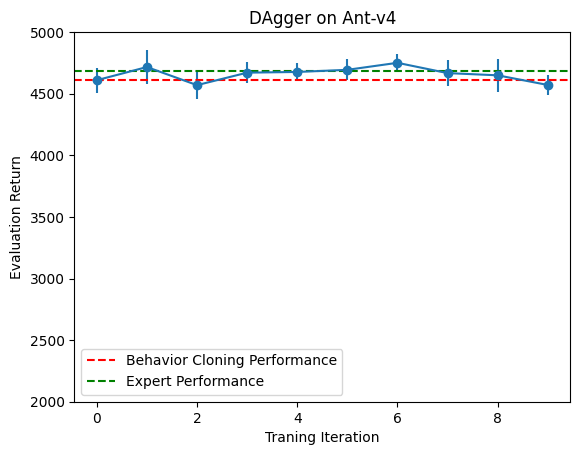

In [16]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
xdata = np.arange(len(logs))
ydata = np.array([log["Eval_AverageReturn"] for log in logs])
yerr = np.array([log["Eval_StdReturn"] for log in logs])
plt.errorbar(xdata, ydata, yerr=yerr, fmt='o-')
plt.xlabel('Traning Iteration')
plt.ylabel('Evaluation Return')
plt.title('DAgger on Ant-v4')
plt.ylim(2000, 5000)
plt.axhline(y=logs[0]["Eval_AverageReturn"], color='r', linestyle='--', label='Behavior Cloning Performance')
plt.axhline(y=logs[0]["Train_AverageReturn"], color='g', linestyle='--', label='Expert Performance')
plt.legend()  # Add a legend to differentiate the lines

plt.show()

In [ ]:
# args = ArgsBCAnt()
args = ArgsBCHopper()
# args = ArgsDAggerAnt()
# args = ArgsDAggerHopper()

#@title hyperparameter experiments
train_steps = [500, 1000, 2000, 3000, 4000, 5000]
learning_rates = [5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 5e-2]
reward_mean = []
reward_std = []

# for train_step in train_steps:
#   args.num_agent_train_steps_per_iter = train_step
for lr in learning_rates:
  args.learning_rate = lr
  if args.do_dagger:
      logdir_prefix = 'q2_'  # The autograder uses the prefix `q2_`
      assert args.n_iter>1, ('DAgger needs more than 1 iteration (n_iter>1) of training, to iteratively query the expert and train (after 1st warmstarting from behavior cloning).')
  else:
      logdir_prefix = 'q1_'  # The autograder uses the prefix `q1_`
      assert args.n_iter==1, ('Vanilla behavior cloning collects expert data just once (n_iter=1)')

  data_path ='/content/cs285_f2023/hw1/data'
  if not (os.path.exists(data_path)):
      os.makedirs(data_path)
  logdir = logdir_prefix + args.exp_name + '_' + args.env_name + \
          '_' + time.strftime("%d-%m-%Y_%H-%M-%S")
  logdir = os.path.join(data_path, logdir)
  args['logdir'] = logdir
  if not(os.path.exists(logdir)):
      os.makedirs(logdir)

  ## run training
  print(args.logdir)
  logs = run_training_loop(args)
  reward_mean.append(logs["Eval_AverageReturn"])
  reward_std.append(logs["Eval_StdReturn"])

/content/cs285_f2023/hw1/data/q1_bc_hopper_Hopper-v4_11-09-2023_22-56-09
########################
logging outputs to  /content/cs285_f2023/hw1/data/q1_bc_hopper_Hopper-v4_11-09-2023_22-56-09
########################
Using GPU id 0
Loading expert policy from... cs285/policies/experts/Hopper.pkl
obs (1, 11) (1, 11)
Done restoring expert policy...


********** Iteration 0 ************


Training agent using sampled data from replay buffer...

Beginning logging procedure...

Eval_AverageReturn : 62.920230865478516
Eval_StdReturn : 42.00090789794922
Eval_MaxReturn : 254.75094604492188
Eval_MinReturn : -0.5949090719223022
Eval_AverageEpLen : 42.77777777777778
Train_AverageReturn : 3717.5129936182307
Train_StdReturn : 0.3530361779417035
Train_MaxReturn : 3717.8660297961724
Train_MinReturn : 3717.159957440289
Train_AverageEpLen : 1000.0
Training Loss : 1.2318785190582275
Train_EnvstepsSoFar : 0
TimeSinceStart : 7.068130970001221
Initial_DataCollection_AverageReturn : 3717.5129936182307
Done lo

In [ ]:
saved_reward_mean = reward_mean
saved_reward_std = reward_std

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


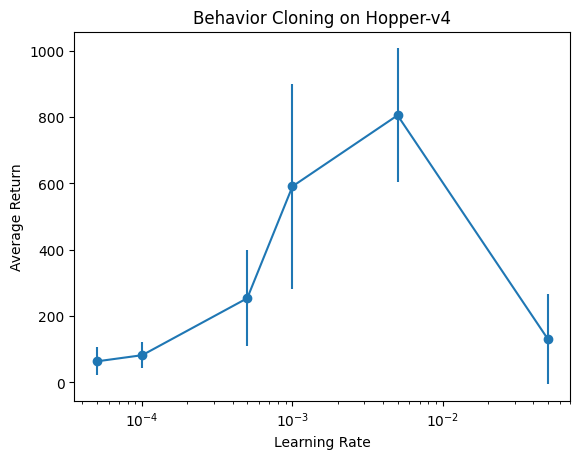

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()
xdata = np.array(learning_rates)
ydata = np.array(reward_mean)
yerr = np.array(reward_std)
plt.errorbar(xdata, ydata, yerr=yerr, fmt='o-')
plt.xlabel('Learning Rate')
plt.ylabel('Average Return')
plt.title('Behavior Cloning on Hopper-v4')
plt.xscale('log')
plt.show()

In [ ]:
#@markdown You can visualize your runs with tensorboard from within the notebook

%reload_ext tensorboard
%tensorboard --logdir /content/cs285_f2023/hw1/data

## Running DAgger (Problem 2)
Modify the settings above:
1. check the `do_dagger` box
2. set `n_iters` to `10`
3. set `exp_name` to `dagger_{env_name}`
and then rerun the code.